# CSC2042S 2025 Assignment 1: Unsupervised Learning
### Maryam Abrahams
### ABRMAR043
### 18th August 2025

## Part 1:  data preprocessing

Conducting exploratory analysis and visualising data using t-SNE dimensionality reduction and the scikit-learn toolbox. Part and parcel of this analysis is the proper documentation alongside it, including justifications, characteristics, and the impact of each preprocessing decision.

T-SNE (t-distributed stochastic neighbour embedding ) takes a high-dimensional dataset and reduces it to a low-dimensional graph, which retains a lot of the data. It does so largely through clustering and maintaining variance, similar to the process of Principal Component Analysis.

In [2]:
# imports, setup, and understanding our data

import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

df = pd.read_csv("WDICSV.csv")
display(df.head())

# To preprocess the data, we want to take this high-dimensional dataset and reduce it to a low-dimensional one

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,Africa Eastern and Southern,AFE,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,18.001597,18.558234,19.043572,19.586457,20.192064,20.828814,21.372164,22.100884,NaN,NaN
1,Africa Eastern and Southern,AFE,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.RU.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,7.096003,7.406706,7.666648,8.020952,8.403358,8.718306,9.097176,9.473374,NaN,NaN
2,Africa Eastern and Southern,AFE,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.UR.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,38.488233,38.779953,39.068462,39.445526,39.818645,40.276374,40.687817,41.211606,NaN,NaN
3,Africa Eastern and Southern,AFE,Access to electricity (% of population),EG.ELC.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,33.922276,38.859598,40.223744,43.035073,44.390861,46.282371,48.127211,48.801258,50.668330,NaN
4,Africa Eastern and Southern,AFE,"Access to electricity, rural (% of rural popul...",EG.ELC.ACCS.RU.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,16.527554,24.627753,25.432092,27.061929,29.154282,31.022083,32.809138,33.783960,35.375216,NaN


To perform t-SNE on our dataset, we must first reshape the data in such a way that t-SNE will be effective, removing missing features and very incomplete country years so that we don't have such a massive amount of missing data as well as reshaping the data to be better for clustering:

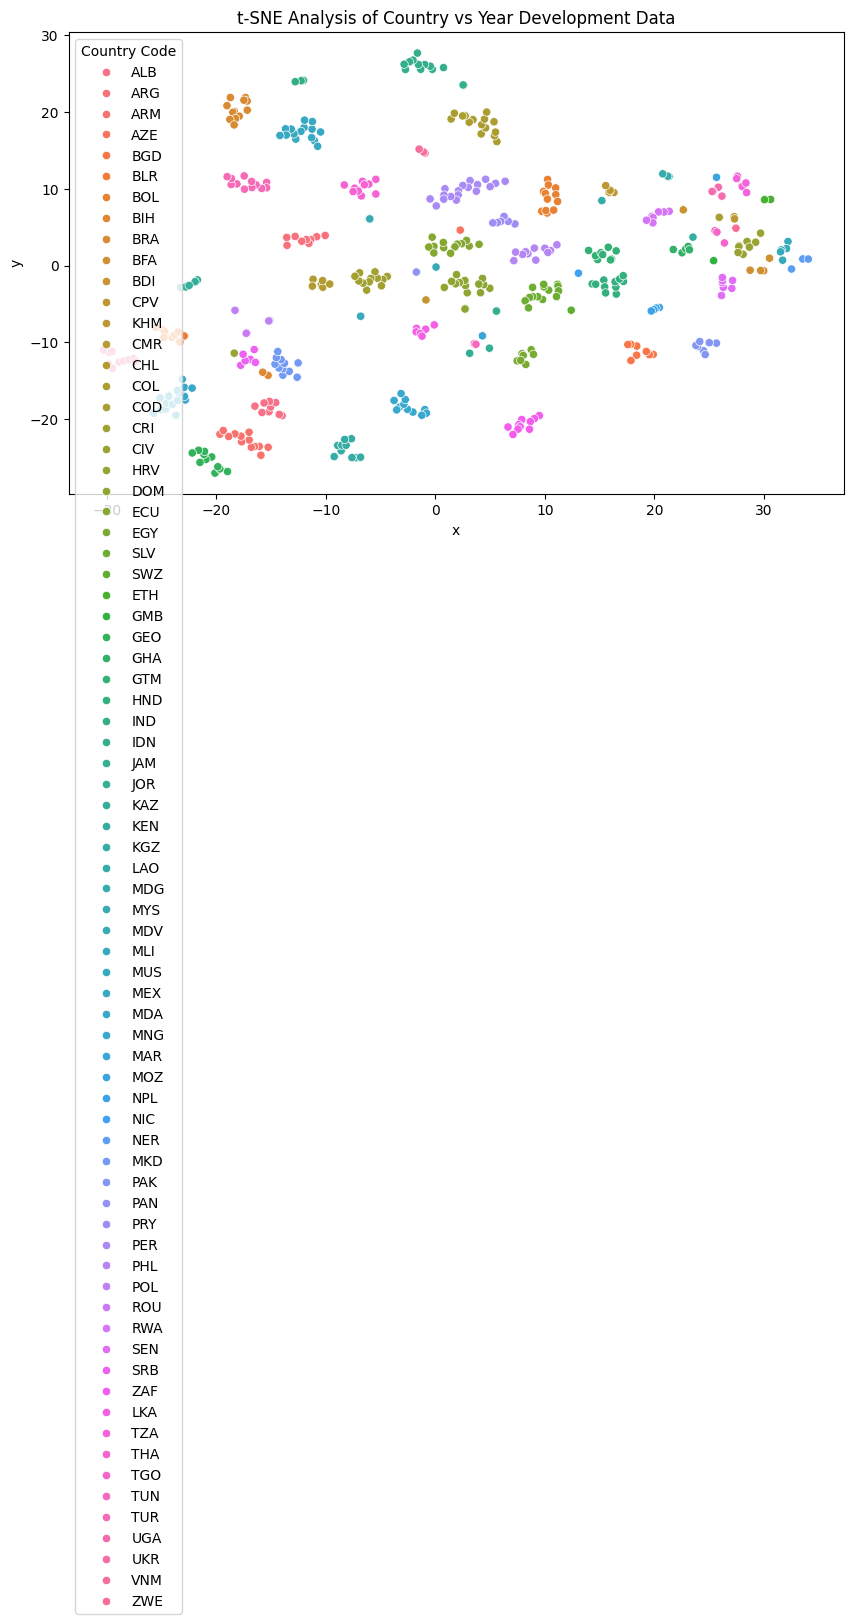

In [16]:
# Reshaping so that there's (Country-year) rows

df_long = df.melt(
    id_vars=['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'],
    var_name = 'Year', 
    value_name = 'Value'
)


df_wide = df_long.pivot_table(
    index = ['Country Name', 'Country Code', 'Year'],
    columns = 'Indicator Code', 
    values = 'Value'
).reset_index()

# Cleaning the missing data
numeric_pt = df_wide.drop(['Country Name', 'Country Code', 'Year'], axis=1).notna().mean(axis=1) >= 0.7
df_wide = df_wide[numeric_pt]

features = df_wide.drop(['Country Name', 'Country Code', 'Year'], axis=1)
features = features.fillna(features.mean())

# first I must drop entirely empty rows 
features = features.dropna(axis=1, how='all')


# Conducting t-SNE dimensionality reduction on our dataframe
# resources used: https://youtu.be/85XaciPBCkw

# Scaling features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

m = TSNE(n_components=2, learning_rate = 50)
tsne_features = m.fit_transform(features_scaled)

df_wide['x'] = tsne_features[:,0]
df_wide['y'] = tsne_features[:,1]

# Ordering countries by value instead of numerically
#country_order = df_wide.groupby('Indicator Code')['x'].mean().sort_values().index

plt.figure(figsize=(10,6))
sns.scatterplot(x='x', y ='y', hue='Country Code', data = df_wide)
plt.title("t-SNE Analysis of Country vs Year Development Data")
plt.show()

## Part 2: K-means clustering; Initialization

Selecting k initial centroids randomly from the dataset where k is the number of clusters you want to find.